# Neural Network Model

## Step 1: Reading cleaned_cancer_data.csv from Resources folder to create a Pandas DataFrame.

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

#  Import and read the charity_data.csv.
import pandas as pd
data_df = pd.read_csv("Resources/cleaned_cancer_data.csv")
data_df.head()

,Unnamed: 0.1,Unnamed: 0,Diagnosis Age,Fraction Genome Altered,Mutation Count,Overall Survival Status,TMB (nonsynonymous),Cancer Type Detailed,Prior Cancer Diagnosis Occurence,Smoking History,Sex,Person Cigarette Smoking History Pack Year Value
0,159,159,70,0.4565,189,0:LIVING,6.300000,1,0,1,0,38.0
1,160,160,67,0.2221,288,0:LIVING,9.633333,1,0,1,0,52.0
2,161,161,79,0.2362,296,1:DECEASED,9.833333,1,0,1,1,47.0
3,162,162,68,0.0854,1625,0:LIVING,54.233333,1,1,1,0,62.0
4,163,163,66,0.0661,122,0:LIVING,4.066667,1,1,1,0,20.0


In [2]:
# Dropping unneccesary columns
clean_data_df = data_df.drop(["Unnamed: 0.1","Unnamed: 0"],axis=1)
clean_data_df

,Diagnosis Age,Fraction Genome Altered,Mutation Count,Overall Survival Status,TMB (nonsynonymous),Cancer Type Detailed,Prior Cancer Diagnosis Occurence,Smoking History,Sex,Person Cigarette Smoking History Pack Year Value
0,70,0.4565,189,0:LIVING,6.300000,1,0,1,0,38.0
1,67,0.2221,288,0:LIVING,9.633333,1,0,1,0,52.0
2,79,0.2362,296,1:DECEASED,9.833333,1,0,1,1,47.0
3,68,0.0854,1625,0:LIVING,54.233333,1,1,1,0,62.0
4,66,0.0661,122,0:LIVING,4.066667,1,1,1,0,20.0
...,...,...,...,...,...,...,...,...,...,...
977,75,0.2382,211,1:DECEASED,7.033333,0,0,1,1,1.0
978,63,0.5420,101,1:DECEASED,3.400000,0,1,1,0,2.5
979,71,0.4405,216,1:DECEASED,7.200000,0,0,1,1,2.5
980,68,0.0598,109,0:LIVING,3.633333,1,0,1,1,95.0


In [3]:
clean_data_df['Overall Survival Status'] = clean_data_df['Overall Survival Status'].replace(
    {'0:LIVING': 0,
     '1:DECEASED': 1
     })

C:\Users\arwal\AppData\Local\Temp\ipykernel_6904\79643189.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clean_data_df['Overall Survival Status'] = clean_data_df['Overall Survival Status'].replace(


In [4]:
# Checking data types
clean_data_df.nunique()
clean_data_df.dtypes

Diagnosis Age                                         int64
Fraction Genome Altered                             float64
Mutation Count                                        int64
Overall Survival Status                               int64
TMB (nonsynonymous)                                 float64
Cancer Type Detailed                                  int64
Prior Cancer Diagnosis Occurence                      int64
Smoking History                                       int64
Sex                                                   int64
Person Cigarette Smoking History Pack Year Value    float64
dtype: object

In [5]:
# Step 2: Creating and separating labels (y) and features (X) from dummies DataFrame.
X = clean_data_df.copy()
X.drop("Overall Survival Status",axis=1,inplace=True)
y = clean_data_df["Overall Survival Status"]

# Splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

## Step 3: Scaling the data features (X & y) for the model.

In [6]:
scaler = StandardScaler()

# Fitting StandardScaler
X_scaler = scaler.fit(X_train)

# Scaling the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [12]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])

    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=30,
        step=2), activation=activation, input_dim=len(X_train_scaled[0])))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=30,
            step=2),
            activation=activation))

    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

    return nn_model

In [13]:
# Import the kerastuner library
import keras_tuner as kt
tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=30,
    hyperband_iterations=2)

Reloading Tuner from .\untitled_project\tuner0.json


In [14]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=30,validation_data=(X_test_scaled,y_test))

Trial 174 Complete [00h 00m 09s]
val_accuracy: 0.7195122241973877

Best val_accuracy So Far: 0.727642297744751
Total elapsed time: 00h 15m 02s


In [15]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'tanh',
 'first_units': 7,
 'num_layers': 5,
 'units_0': 1,
 'units_1': 1,
 'units_2': 1,
 'units_3': 3,
 'units_4': 7,
 'units_5': 5,
 'tuner/epochs': 17,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 1,
 'tuner/round': 0}

In [17]:
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - 42ms/step - accuracy: 0.7276 - loss: 0.6055
Loss: 0.6055421829223633, Accuracy: 0.727642297744751


# Step 4: Compile and Train Model

In [7]:
# Defining model through dense layers and number of neurons for each layer
num_input_features = len(X_train_scaled[0])
hidden_nodes_1 = 50
hidden_nodes_2 = 50
hidden_nodes_3 = 50

# Create a Keras Sequential model and add more than one Dense hidden layer
nn_model = tf.keras.models.Sequential()

nn_model.add(tf.keras.layers.Dense(units=hidden_nodes_1, activation="relu", input_dim=num_input_features))

nn_model.add(tf.keras.layers.Dense(units=hidden_nodes_2, activation="relu"))

nn_model.add(tf.keras.layers.Dense(units=hidden_nodes_3,activation="relu"))

nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the Sequential model
nn_model.summary()

c:\Users\arwal\anaconda3\envs\dev\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,651 (22.07 KB)

 Trainable params: 5,651 (22.07 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compile the model and train over more than 100 epochs
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

fit_model = nn_model.fit(X_train_scaled, y_train, epochs=200)

Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5854 - loss: 0.6674
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7196 - loss: 0.5941 
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7023 - loss: 0.5995 
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7006 - loss: 0.5938 
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7144 - loss: 0.5780 
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6991 - loss: 0.5850 
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7215 - loss: 0.5610 
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7494 - loss: 0.5293 
Epoch 9/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7233 - loss: 0.5684 
Epoch 10/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7318 - loss: 0.5455 
Epoch 11/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7227 - loss: 0.5608 
Epoch 12/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

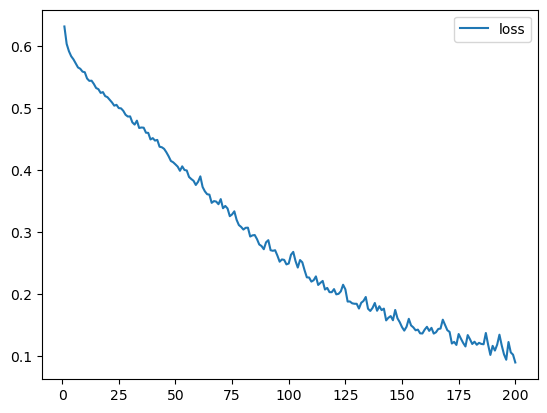

In [13]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")
plt.show()

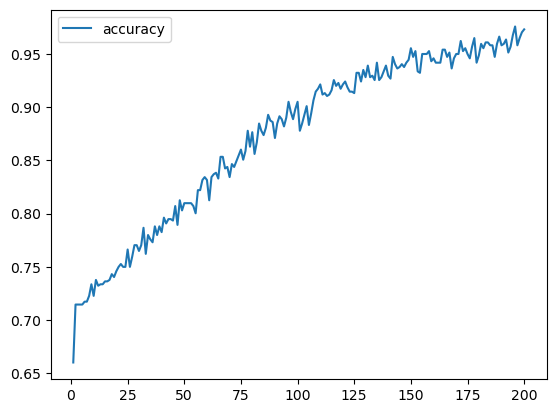

In [14]:
# Plot the accuracy
history_df.plot(y="accuracy")
plt.show()

In [15]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - 3ms/step - accuracy: 0.5691 - loss: 2.2626
Loss: 2.2625904083251953, Accuracy: 0.5691056847572327
